In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.4 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자

In [3]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-01-15,54100,54700,53500,53700,18625025,-0.003711
2025-01-16,54200,55000,54100,54300,18627298,0.011173
2025-01-17,53800,54100,53200,53700,18805344,-0.011050
2025-01-20,53600,53900,53300,53400,11822531,-0.005587
2025-01-21,53700,54300,53300,53700,11213564,0.005618


# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

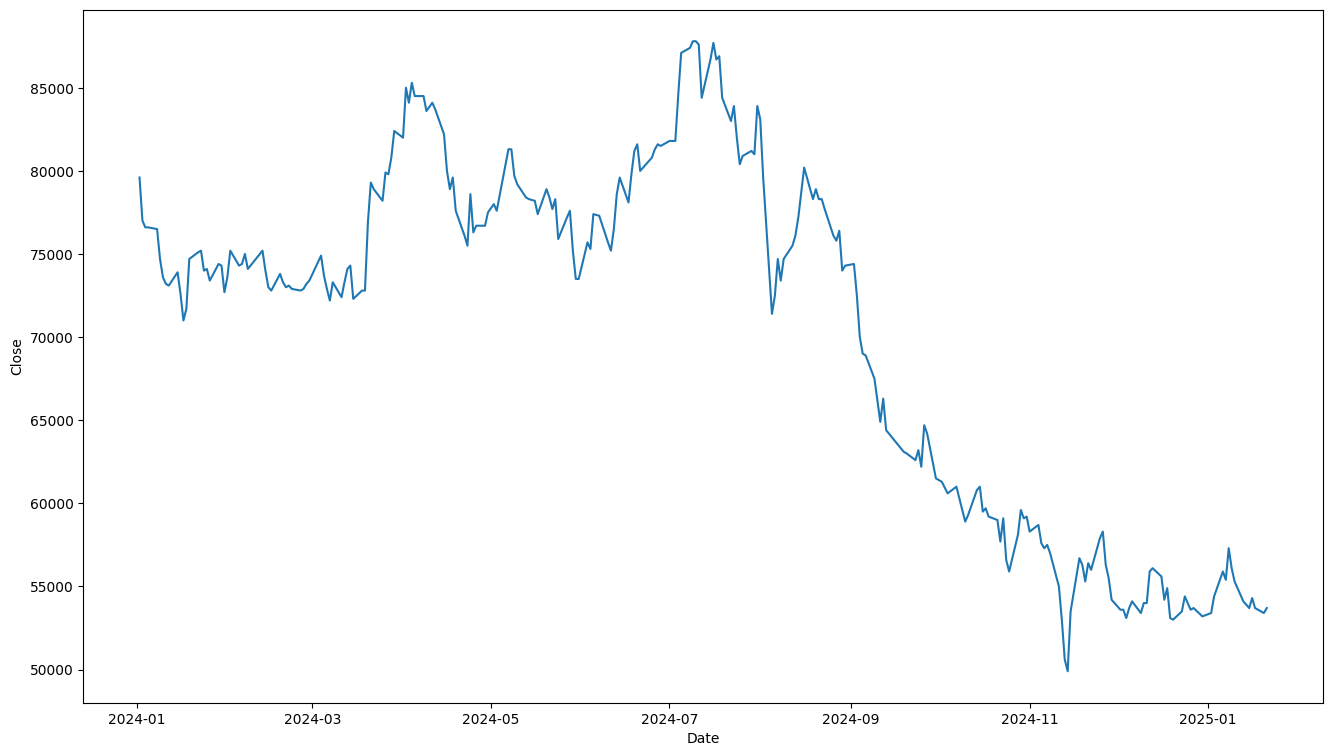

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [7]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [8]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [9]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([53, 5, 4]) torch.Size([53, 1])


<ipython-input-8-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [10]:
x_train_seq

tensor([[[0.7311, 0.7568, 0.7608, 0.1872],
         [0.7389, 0.7297, 0.7285, 0.2796],
         [0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658]],

        [[0.7389, 0.7297, 0.7285, 0.2796],
         [0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658],
         [0.7102, 0.7000, 0.6559, 0.3651]],

        [[0.6762, 0.6892, 0.7043, 0.1507],
         [0.6919, 0.6838, 0.7124, 0.0701],
         [0.6997, 0.6946, 0.7124, 0.0658],
         [0.7102, 0.7000, 0.6559, 0.3651],
         [0.6475, 0.6324, 0.6263, 0.2496]],

        ...,

        [[0.2089, 0.1811, 0.1801, 0.4750],
         [0.1514, 0.1378, 0.1586, 0.3613],
         [0.1436, 0.1811, 0.1559, 0.4003],
         [0.2037, 0.2108, 0.1989, 0.4122],
         [0.2324, 0.2162, 0.2339, 0.2412]],

        [[0.1514, 0.1378, 0.1586, 0.3613],
         [0.1436, 0.1811, 0.1559, 0.4003],
         [0.2037, 0.2108, 0.1989

In [11]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

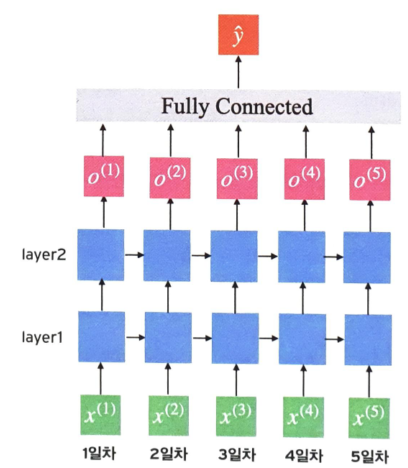

In [12]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [13]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [14]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [15]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [16]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0443
[epoch : 10] loss: 0.0051
[epoch : 20] loss: 0.0048
[epoch : 30] loss: 0.0041
[epoch : 40] loss: 0.0037


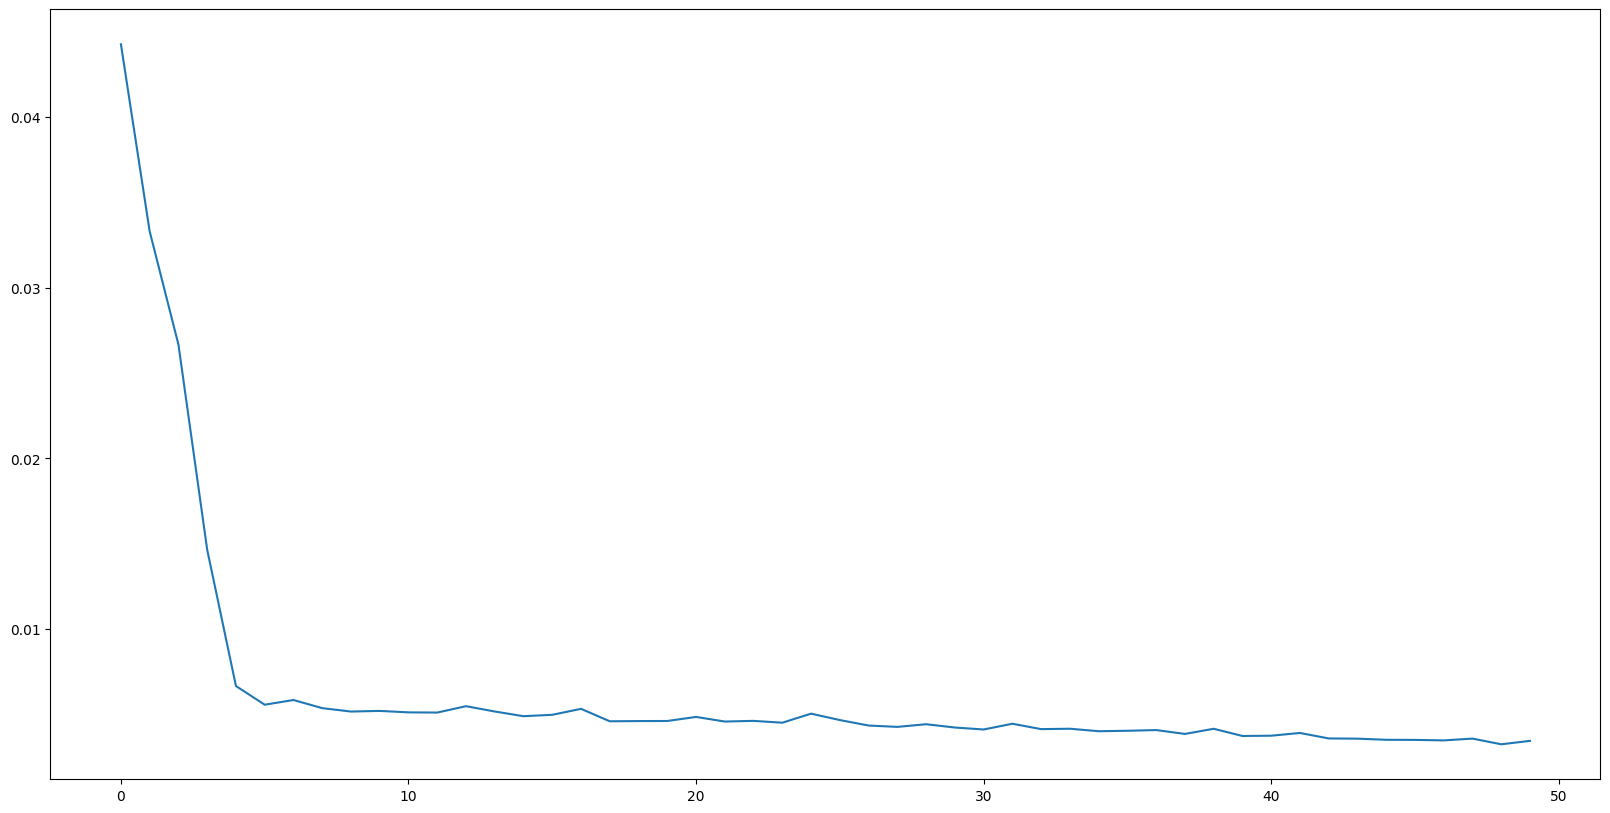

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [18]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

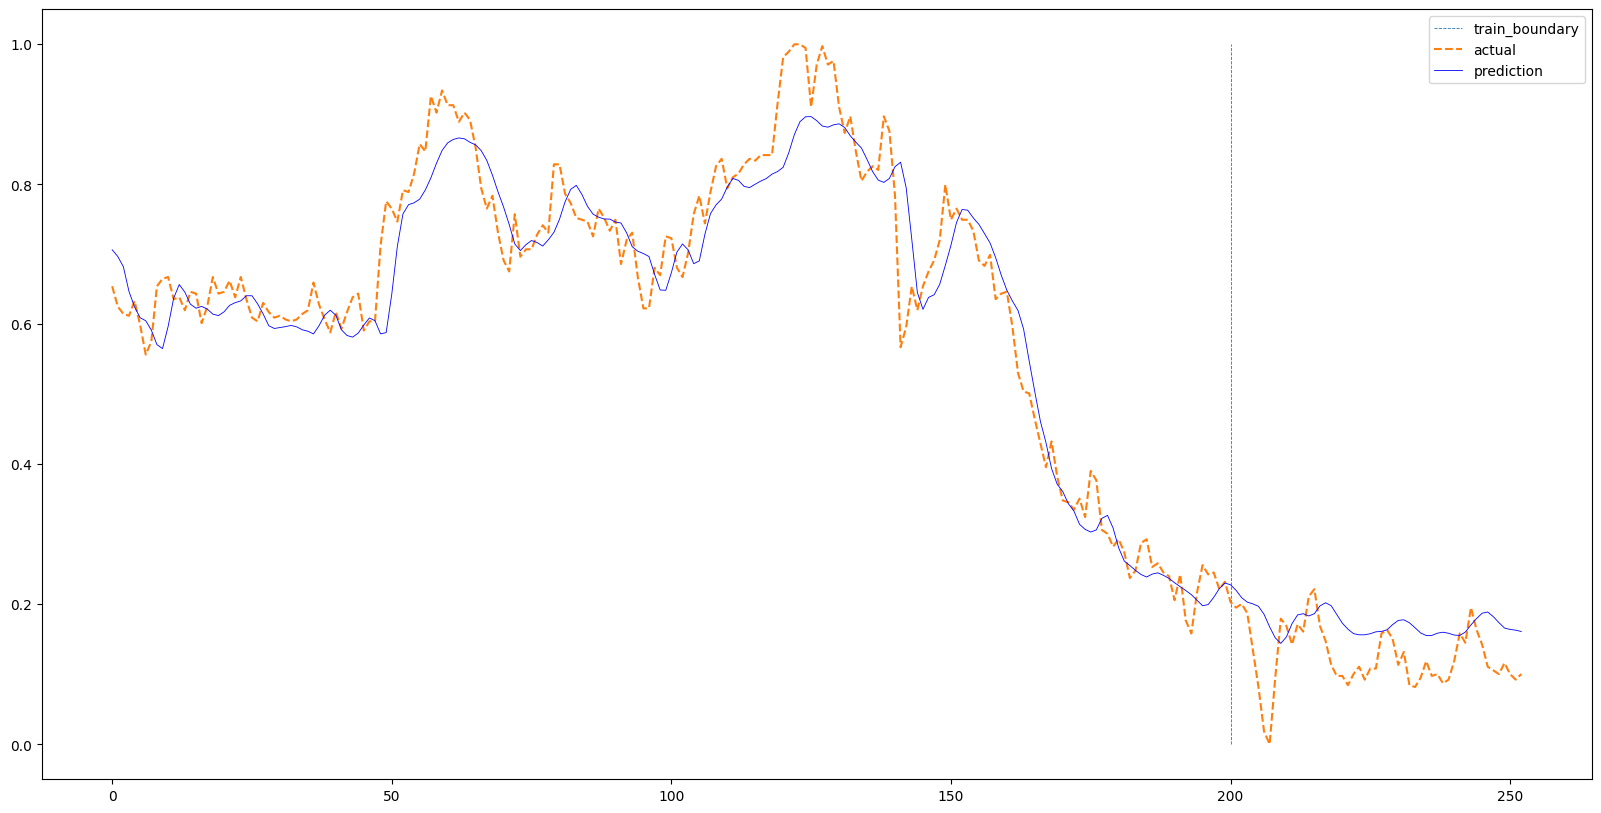

In [19]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [20]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [22]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [23]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1572
[epoch: 10] loss: 0.0055
[epoch: 20] loss: 0.0044
[epoch: 30] loss: 0.0041
[epoch: 40] loss: 0.0041


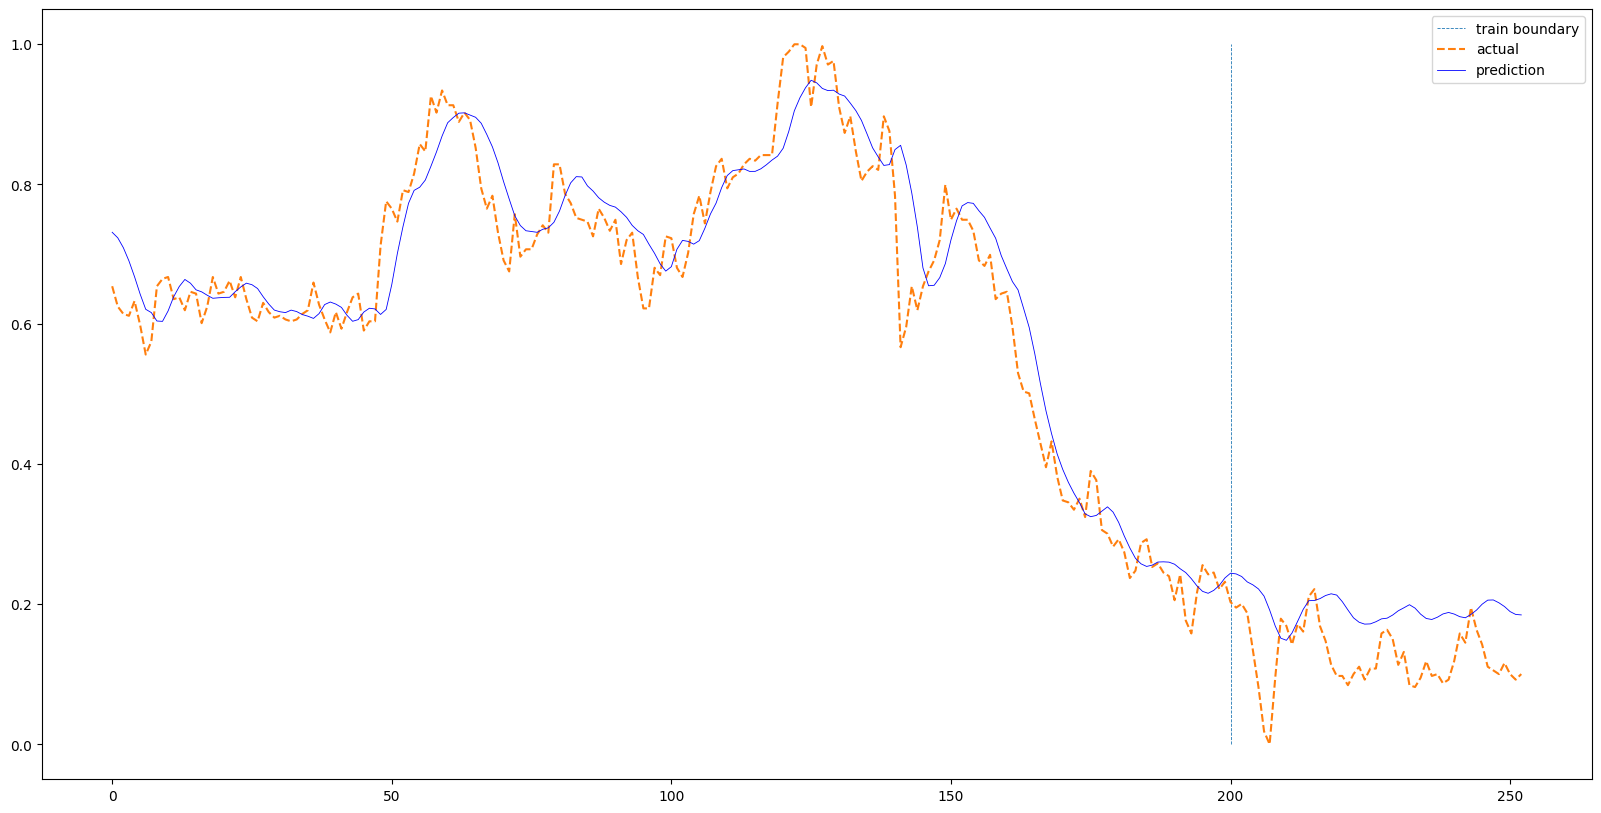

In [25]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

이와 관련된 주가 예측 프로젝트를 해본적이 있는데 RNN과 LSTM **모두 Time Shift 현상을 해결하지 못한다는 문제점**이 존재한다. 이는 어떤 주가 데이터에서도 똑같은 현상이 일어나는데 위에 삼성전자 종가 그래프에서 예측한 값이 실제 값과 매우 유사하게 움직여, 학습이 원활하게 진행된 것 처럼 보인다.

하지만 실상은 LSTM과 RNN의 모델이 **복잡하고 규칙이 존재하지 않은 주가 데이터에 대해서 규칙을 찾지 못해 단순히 며칠전 종가의 값을 그대로 가져오는 cheating**을 하게 된다. 이러한 문제를 time-shift 라고 하며 LSTM과 RNN 모델의 크기를 충분히 늘리더라도 더 정확하게 전날의 종가를 가져와 cheating을 할 뿐 실제로 유의미한 예측이 불가능하다

더 나아가 이를 해결하기 위해 전처리를 진행하고 hyperparameter tuning, 앙상블 기법을 추가하거나 ARIMA, BI-LSTM등의 모델을 이용하여 데이터를 정상성이 있게 비꾼다든지, 미래의 데이터를 활용한다고 하더라도 이러한 문제를 해결할 수 없다. 이는 곧 고전적인 시계열 모델인 RNN과 LSTM의 모델이 매우 복잡한 패턴에 대해서 한계가 있다고 볼 수도 있고, 주가 데이터 자체에 패턴이 존재하지 않기 때문에 학습 자체가 불가능한 데이터라고 판단할 수도 있다.

따라서 이번 과제에서 깨달을 수 있는 것은 sequence 데이터에 대해 RNN과 LSTM을 통해 처리가 가능하다라고 보면 좋을 것 같다. (텍스트 기반 데이터에 더 좋은 성능을 보인다)

이러한 문제점으로 인해, 실제 주가 예측을 위해서 강화학습을 사용한다거나 transformer 기반의 모델들이 사용되고 있지만, 실제로 LLM에서 gpt 모델이 나온 것처럼 이 분야에서 대표가 되는 모델이 나온 상태가 아니며 SOTA 모델 역시 확실한 성능이 나오지 못하는 상황이다. (시계열 데이터들의 경우 기상 데이터, 주식 데이터 등 매우 다양한 데이터가 존재하고 이를 한번의 처리할 수 있는 범용적인 모델이 나오기 어렵다. 그렇기 때문에 각 도메인의 특징에 따른 특수한 모델이 나와야하며, 이러한 이유들이 아직 대표적인 주가 예측 관련 모델이 나오지 못한 이유 중 하나이다)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail